In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets

**1. Можно ли отобрать наиболее значимые признаки с помощью PCA?**

**Ответ:** Нет. Так как при использовании метода PCA создаются совершенно новые признаки, следовательно, мы не можем судить об их важности влияния на целевую переменную (к примеру, может сформироваться комбинация двух признаков средней важности, но вместе они будут переносить больше информации при сокращении размерности).

**2. (*) Написать свою реализацию метода главных компонент с помощью сингулярного разложения с использованием функции [numpy.linalg.svd()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html)**

In [ ]:
# Функция для масштабирования выборки

def cacl_std_data(data):
    X_ = X.astype(float)

    rows, cols = X_.shape

    # центрирование - вычитание из каждого значения среднего по признаку
    means = X_.mean(axis=0)
    for i in range(rows):
        for j in range(cols):
            X_[i, j] -= means[j]

    # деление каждого значения на стандартное отклонение
    std = np.std(X_, axis=0)
    for j in range(cols):
        for i in range(rows):
            X_[i, j] /= std[j]
    return X_

In [ ]:
# Загрузим игрушечный датасет из sklearn
iris = datasets.load_iris()
X = iris.data

In [ ]:
# Метод главных компонент через функцию numpy.linalg.svd() с встроенной стандартизацией признаков

def PCA_method(data, components=None):
    # Отмасштабируем признаки
    data_st = cacl_std_data(data)

    # Сделаем сингулярное разложение матрицы
    U, s, W = np.linalg.svd(data_st)

    # Приведем список диагональных элементов к виду диагональной матрицы
    D = np.zeros_like(data_st, dtype=float)
    D[np.diag_indices(min(data_st.shape))] = s

    print(f'Проверка:\n{data_st[0]} - Строка из исходной матрицы\n{np.dot(np.dot(U, D), W)[0]} - Строка из матрицы после сингулярного разложения')

    # Запишем собственные значения
    eig_values = np.diagonal(np.dot(D.T, D))
    
    # Запишем собственные вектора
    eig_vectors = W.T

    # Найдем доли дисперсии, описываемые каждой из компонент
    eig_sum = sum(eig_values)
    var_exp = [(i / eig_sum) * 100 for i in eig_values]
    cum_var_exp = np.cumsum(var_exp)
    print(f'\nДоля дисперсии, описываемая каждой из компонент \n{var_exp}')
    print(f'Кумулятивная доля дисперсии по компонентам \n{cum_var_exp}')

    # Отбираем наиболее информативные компоненты
    W_new = eig_vectors[:, :components]

    # Сформируем новую матрицу "объекты-признаки"
    Z = data_st.dot(W_new)

    return Z

In [ ]:
Z = PCA_method(X, components=2)

Проверка:
[-0.90068117  1.01900435 -1.34022653 -1.3154443 ] - Строка из исходной матрицы
[-0.90068117  1.01900435 -1.34022653 -1.3154443 ] - Строка из матрицы после сингулярного разложения

Доля дисперсии, описываемая каждой из компонент 
[72.96244541329989, 22.850761786701742, 3.6689218892828794, 0.5178709107154799]
Кумулятивная доля дисперсии по компонентам 
[ 72.96244541  95.8132072   99.48212909 100.        ]


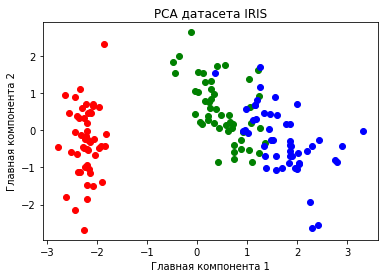

In [ ]:
plt.figure()
y = iris.target
for c, i in zip("rgb", [0, 1, 2]):
    plt.scatter(Z[y==i, 0], Z[y==i, 1], c=c)
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('PCA датасета IRIS')
plt.show()

**3. (*) Обучить любую модель классификации на датасете IRIS до применения PCA и после него. Сравнить качество классификации по отложенной выборке.**

In [ ]:
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [ ]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [ ]:
# Обучим модель Случайного леса БЕЗ понижения размерности

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

clf = RandomForestClassifier(max_depth=2, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(accuracy_metric(y_test, y_pred))

100.0


In [ ]:
# Обучим модель Случайного леса ПОСЛЕ понижения размерности

X_train_Z, X_test_Z, y_train_Z, y_test_Z = model_selection.train_test_split(Z, y, test_size=0.25, random_state=42)

clf_Z = RandomForestClassifier(max_depth=2, random_state=42)
clf_Z.fit(X_train_Z, y_train_Z)
y_pred_Z = clf_Z.predict(X_test_Z)

print(accuracy_metric(y_test_Z, y_pred_Z))

86.8421052631579


**Вывод:** Из проведенного эксперимента можно заключить, что точность предсказания после понижения размерности при прочих равных параметрах падает.